# Create frequent public transport stops analysis


This notebook describes a process to retain public transit stops points with frequent services

### Method: Stop headway analysis using average frequencies of departure during day time

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during daytime over departure for normal weekdays
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)


### Process:
1. set up study region GTFS analysis parameters (gtfs_config.py)  
2. load GTFS data into an UrbanAccess transit data frame
    - stops will be loaded limited within study region buffered bounding box
3. select a usual or representative one week during the feeds period that should fully capture the provided PT services in a city. 
    - a suitable "usual" week should contain at least 0.9 (default) of the total maximum of trips.
4. Stop headway analysis using average departure time during usual weekday (Monday-Friday) daytime (7am-7pm)


Previous working branch using SQL:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  


In [1]:
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

In [2]:
#conda install -c udst urbanaccess

In [17]:
import pandas as pd
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime
from datetime import timedelta


import urbanaccess as ua

# module with functions to load GTFS data into dataframes
# revise based on origional load function from UrbanAccess, take out the add agency and route type features
import ua_load 

# module with functions to calculate the average headway during the timeframe over departure
import gtfs_headway_analysis as gha

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [18]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [19]:
# list of cities
cities = [{'cityname': 'adelaide', 'region': 'au', 'crs': 'epsg:7845'},
          {'cityname': 'auckland', 'region': 'nz', 'crs': 'epsg:2193'},
          {'cityname': 'baltimore', 'region': 'us', 'crs': 'epsg:32618'},
          {'cityname': 'bangkok', 'region': 'th', 'crs': 'epsg:32647'},
          {'cityname': 'barcelona', 'region': 'es', 'crs': 'epsg:25831'},
          {'cityname': 'belfast', 'region': 'gb', 'crs': 'epsg:29902'},
          {'cityname': 'bern', 'region': 'ch', 'crs': 'epsg:32633'},
          {'cityname': 'chennai', 'region': 'in', 'crs': 'epsg:32644'},
          {'cityname': 'cologne', 'region': 'de', 'crs': 'epsg:32631'},
          {'cityname': 'ghent', 'region': 'be', 'crs': 'epsg:32631'},
          {'cityname': 'graz', 'region': 'at', 'crs': 'epsg:32633'},
          {'cityname': 'hanoi', 'region': 'vn', 'crs': 'epsg:32648'},
          {'cityname': 'hong_kong', 'region': 'hk', 'crs': 'epsg:32650'},
          {'cityname': 'lisbon', 'region': 'pt', 'crs': 'epsg:3763'},
          {'cityname': 'melbourne', 'region': 'au', 'crs': 'epsg:7845'},
          {'cityname': 'mexico_city', 'region': 'mx', 'crs': 'epsg:32614'},
          {'cityname': 'odense', 'region': 'dk', 'crs': 'epsg:32632'},
          {'cityname': 'olomouc', 'region': 'cz', 'crs': 'epsg:32633'},
          {'cityname': 'phoenix', 'region': 'us', 'crs': 'epsg:32612'},
          {'cityname': 'sao_paulo', 'region': 'br', 'crs': 'epsg:32723'},
          {'cityname': 'seattle', 'region': 'us', 'crs': 'epsg:32610'},
          {'cityname': 'sydney', 'region': 'au', 'crs': 'epsg:7845'},
          {'cityname': 'valencia', 'region': 'es', 'crs': 'epsg:25830'},
          {'cityname': 'vic', 'region': 'es', 'crs': 'epsg:25831'}]

In [6]:
# get lat lon bounding box for each study region from study region input geopackage
# for plotting and for limiting the stops analysis within the study region
     
for i in range(len(cities)):
    city = cities[i]['cityname']
    region = cities[i]['region']
    crs = cities[i]['crs']
    
    geopackagePath = '../data/input/{city}_{region}_2019_1600m_buffer.gpkg'.format(
            city=city, region=region)
    # load shapefile
    shape = gpd.GeoDataFrame.from_file(geopackagePath, 
                  layer='urban_study_region')
    
    polygon = shape['geometry'].iloc[0]
    # create buffer to consider edge effect
    polygon_buffered = polygon.buffer(500)
        
    # project to lat lon
    polygon_proj = ox.project_geometry(polygon_buffered, crs=crs, to_crs=None, to_latlong=True)

    # get bounding box
    bbox = polygon_proj[0].bounds
    print(city, ' : ', bbox)
    
#minx , miny , maxx , maxy

adelaide  :  (138.46098212857206, -35.15966609024628, 138.7483172991119, -34.71454282915053)
auckland  :  (174.57726564925753, -37.089137447205424, 174.98796590474333, -36.68399669533544)
baltimore  :  (-76.71732081546881, 39.197419266639976, -76.5236521818912, 39.376708110613045)
bangkok  :  (100.3242991903801, 13.581639211414096, 100.89708064810183, 13.95971650444916)
barcelona  :  (2.0822008749659653, 41.31251726667463, 2.2342770048946647, 41.47251143638445)
belfast  :  (-6.069370813429028, 54.53841202212306, -5.808356706711118, 54.66949357864951)
bern  :  (7.35925731707479, 46.91988034541113, 7.502082155046321, 46.99460688285972)
chennai  :  (80.13557688345986, 12.84745650235429, 80.3375087202582, 13.239675620841895)
cologne  :  (6.8090292419421345, 50.82712108456513, 7.150063369469329, 51.074342237096744)
ghent  :  (3.65756993174172, 50.97975642949553, 3.8406106107978766, 51.192596595895836)
graz  :  (15.37640720799714, 47.008338596794694, 15.503608232543947, 47.12801640229455)
ha

In [111]:
# set up study region GTFS config
# these gtfs parameters are defined in gtfs_config.py file
GTFS = {'adelaide':{'gtfs_filename':'gtfs_input_data/gtfs_au_sa_adelaidemetro_20191004',
                    'gtfs_provider' : 'Adelaide Metro',
                    'gtfs_year' : '2019',
                    # define month and day for feeds start and end date
                    'start_date_mmdd' : '20191008',
                    'end_date_mmdd' : '20191205',
                    # get bounding box from study region boundary shapefile
                    # bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
                    # you can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.
                    # this parameters is optional, for use if wanting remove features outside the bbox when loading feeds
                    'bbox' : (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053),
                    'crs': 'epsg:7845',
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [3],
                                  'peak_time' : ['07:00:00', '09:00:00'],
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': None},
                        'tram':{'route_types': [0],
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'train':{'route_types': [1,2],
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'ferry':{'route_types': [4],
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None}
                    }
                   }
       }
                    



In [112]:
# set up a study region config to run in this notebook
city = 'adelaide'

gtfsfeed_path = GTFS['{}'.format(city)]['gtfs_filename']
start_date=GTFS['{}'.format(city)]['start_date_mmdd']
end_date=GTFS['{}'.format(city)]['end_date_mmdd']

peak_hour = GTFS['{}'.format(city)]['modes']['bus']['day_time']
start_hour = peak_hour[0]
end_hour = peak_hour[1]
bbox = GTFS['{}'.format(city)]['bbox']
crs = GTFS['{}'.format(city)]['crs']


headway_intervals = GTFS['{}'.format(city)]['modes']['bus']['intervals']
route_types = GTFS['{}'.format(city)]['modes']['bus']['route_types']
agency_ids = GTFS['{}'.format(city)]['modes']['bus']['agency_id']



# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Loading GTFS data into a UrbanAccess transit data object


In [91]:
# revise based on origional function from UrbanAccess, take out the add agency and route type features
# we may want to limit the stops within the study region bounding box for efficiency, as some feeds are regional system
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path, validation=True, bbox=bbox, remove_stops_outsidebbox=True)

--------------------------------
GTFS text file header whitespace check completed. Took 3.25 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Records: {}
     stop_id  stop_code                        stop_name  \
29      6693    16518.0   Gawler Central Railway Station   
30      6694    16519.0      Gawler Oval Railway Station   
31      6692    16517.0           Gawler Railway Station   
32      6691    16516.0         Evanston Railway Station   
33      6737    16562.0         Tambelin Railway Station   
...      ...        ...                              ...   
7695   50079        NaN     Broadmeadows Railway Station   
7722   50022        NaN  Seaford Meadows Railway Station   
7723   50080        NaN       Smithfield Railway Station   
7725   50084        NaN         Evanston Railway Station   
7739   50083        NaN         Tambelin Railway Station   

                           stop_desc   stop_lat    stop_lon  zone_id  \
29   

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

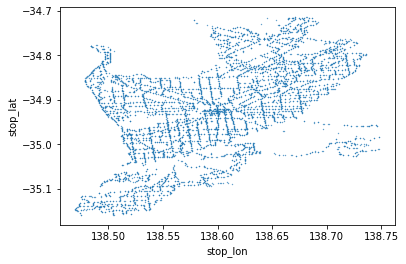

In [92]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Select usual and representative one week for feeds analysis


In [93]:
from gtfs_headway_analysis import set_date_service_table

# Get trip counts per day between the start and end day of the feed.
def get_trip_counts_per_day(loaded_feeds):
    """
    Get trip counts per day between the start and end day of the feed.
    
    Parameters
    ----------
    loaded_feeds: gtfsfeeds_dataframe with GTFS objects
   
   Returns
    -------
    daily_trip_counts : pandas.DataFrame
        Has columns "date" and "trip_counts"
    """
    date_service_df = set_date_service_table(loaded_feeds)
    daily_trip_counts = pd.merge(date_service_df, loaded_feeds.trips, on='service_id').groupby(['date'
                                                    ], sort=False)['trip_id'].count().to_frame('trip_counts')
    daily_trip_counts = daily_trip_counts.sort_index().reset_index()
    return daily_trip_counts


In [94]:
# function revised from gtfspy (reference:https://www.nature.com/articles/sdata201889#Sec21):
# https://github.com/CxAalto/gtfspy/blob/47f1526fee43b83b396c7e75b64a4b9de3b467a0/gtfspy/gtfs.py#L679
def get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9,
                                start_date=None, end_date=None):
    """
    Find a suitable weekly extract start date (monday).
    The goal is to obtain as 'usual' week as possible.
    The weekdays of the weekly extract week should contain
    at least 0.9 (default) of the total maximum of trips.

    Parameters
    ----------
    daily_trip_counts: pandas.DataFrame
        Has columns "date" and "trip_counts"

    weekdays_at_least_of_max: float

    start_date: str or datetime, semi-optional
        if given, overrides the recorded start date in the feed

    end_date: str or datetime, semi-optional
        if given, overrides the recorded end date in the feed,
        must given if start_date is specified
        
    Returns
    -------
    row['date']: int or str or Timestamp

    """

    # make sure the daily trip count is sorted by date
    daily_trip_counts = daily_trip_counts.sort_values('date').reset_index()
    # search start date, defaults to the smallest date in the feed
    if (isinstance(start_date, str) & isinstance(end_date, str)):
        search_start_date = datetime.datetime.strptime(start_date, "%Y%m%d")
        search_end_date = datetime.datetime.strptime(end_date, "%Y%m%d")
        feed_min_date = search_start_date
        feed_max_date = search_end_date
    elif (isinstance(start_date, datetime.datetime) & isinstance(end_date, datetime.datetime)):
        search_start_date = start_date
        search_end_date = end_date
        feed_min_date = search_end_date
        feed_max_date = search_end_date
    else:
        assert start_date is None
        warnings.warn("Start and end date is not given or in wrong formats, defaults to the smallest date when any operations take place.")
        search_start_date = daily_trip_counts['date'].min()
        feed_min_date = search_start_date
        feed_max_date = daily_trip_counts['date'].max()

    assert (feed_max_date - feed_min_date >= datetime.timedelta(days=7)), \
    "Dataset is not long enough for providing week long extracts"

    # get first a valid monday where the search for the week can be started:
    next_monday_from_search_start_date = search_start_date + timedelta(days=(7 - search_start_date.weekday()))

    if not (feed_min_date <= next_monday_from_search_start_date <= feed_max_date):
        warnings.warn("The next monday after the (possibly user) specified download date is not present in the database."
                  "Resorting to first monday after the beginning of operations instead.")
        search_start_date = daily_trip_counts['date'].min()
        feed_min_date = daily_trip_counts['date'].min()
        feed_max_date = daily_trip_counts['date'].max()
        next_monday_from_search_start_date = feed_min_date + timedelta(days=(7 - feed_min_date.weekday()))
    
    # limit feeds within start and end date
    daily_trip_counts = daily_trip_counts[(feed_min_date <= daily_trip_counts['date']) &  (daily_trip_counts['date']<=feed_max_date)]    
    daily_trip_counts = daily_trip_counts.sort_values('date').reset_index()
    
    print('Search start date: ', search_start_date, ', next_monday_from_search_start_date: ', next_monday_from_search_start_date)
    
    # Take 95th percentile to omit special days, if any exist.
    max_trip_count = daily_trip_counts['trip_counts'].quantile(0.95)

    threshold = weekdays_at_least_of_max * max_trip_count
    threshold_fulfilling_days = daily_trip_counts['trip_counts'] > threshold

    # look forward first
    # get the index of the trip:
    search_start_monday_index = daily_trip_counts[daily_trip_counts['date'] == next_monday_from_search_start_date].index[0]

         # get starting point
    while_loop_monday_index = search_start_monday_index
    while len(daily_trip_counts.index) >= while_loop_monday_index + 7:
        if all(threshold_fulfilling_days[while_loop_monday_index:while_loop_monday_index + 5]):
            row = daily_trip_counts.iloc[while_loop_monday_index]
            #return row['date']
        while_loop_monday_index += 7

    while_loop_monday_index = search_start_monday_index - 7
    # then backwards
    while while_loop_monday_index >= 0:
        if all(threshold_fulfilling_days[while_loop_monday_index:while_loop_monday_index + 5]):
            row = daily_trip_counts.iloc[while_loop_monday_index]
            #return row['date']
        while_loop_monday_index -= 7

    return row['date']

In [95]:
# drive usual week starting Monday
# ensured that all weekdays have at least 90% of the maximum number of 
# daily PT trips during the time span of the week-long extract.
daily_trip_counts = get_trip_counts_per_day(loaded_feeds)
usual_start_date = get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9, start_date=start_date, end_date=end_date)
usual_start_date

Search start date:  2019-10-08 00:00:00 , next_monday_from_search_start_date:  2019-10-14 00:00:00


Timestamp('2019-11-25 00:00:00')

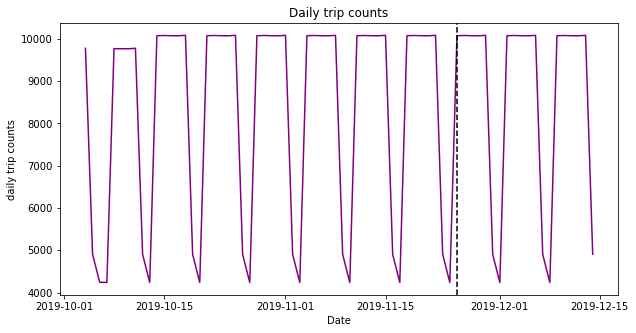

In [96]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 5))

# Add x-axis and y-axis
ax.plot(daily_trip_counts.sort_values('date')['date'],
        daily_trip_counts.sort_values('date')['trip_counts'],
        color='purple')

plt.axvline(x=usual_start_date, color='k', linestyle='--')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="daily trip counts",
       title="Daily trip counts")

plt.show()

Reference: [Kujala et. al. (2018) A collection of public transport network data sets for 25 cities](https://www.nature.com/articles/sdata201889#Sec21)  
"The dates for the temporal filtering were chosen based on the number of daily trips of the included feeds. We ensured that there was a clear weekly periodicity in the feeds, so that working days have roughly the same number of trips and that weekends have a different schedule. Then we selected the dates for the week-long and day-long extracts, where we aimed for a typical work week without major exceptions in the PT operations, such as national holidays. To this end, we ensured that all weekdays have at least 90% of the maximum number of daily PT trips during the time span of the week-long extract."

# Stop headway analysis using average departure time dur weekday daytime

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [97]:
# set the start and end date to usual week of weekday operation (Monday to Friday)
start_date = usual_start_date
end_date = usual_start_date + timedelta(4)

In [98]:
stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

/home/jovyan/work/process/GTFS_freq_stop/gtfs_headway_analysis.py:294: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


In [99]:
# select average departure headway less than or equal to maxi headway frequency intervals
stop_30_mins_headway = stops_headway[stops_headway['headway'] <= 20]

# get spatial features for freqent stops
stop_30_mins_final = pd.merge(stop_30_mins_headway, loaded_feeds.stops, how='left', on='stop_id')

# add stop id geometry
stop_30_mins_final['geometry'] = stop_30_mins_final.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_final = gpd.GeoDataFrame(stop_30_mins_final)

In [100]:
len(stop_30_mins_final)

2462

# Plot all PT stop and freqent PT bus stops

In [101]:
# get the study region boundary gdf
shape = gpd.GeoDataFrame.from_file('gtfs_input_data/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=shape_layer_name)

polygon = shape['geometry'].iloc[0]
crs = shape.crs

polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
shape_proj = gpd.GeoDataFrame(polygon_proj[0]).rename(columns={0:'geometry'})
shape_proj = gpd.GeoDataFrame(shape_proj,  geometry='geometry')

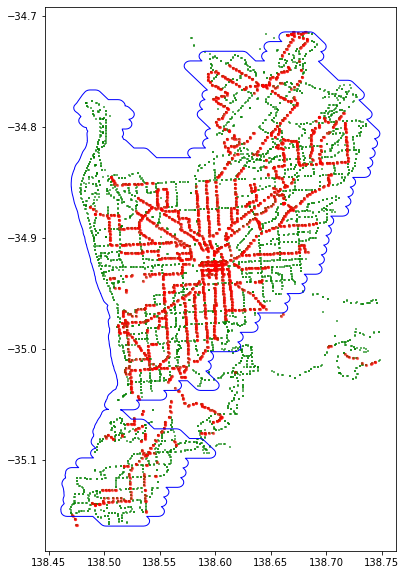

In [102]:
# set spatial geometry for all stops 
loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape_proj.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()

In [103]:
# select stops within study region boundary
len(stop_30_mins_final[(stop_30_mins_final.within(polygon_proj[0]))])

2376

In [104]:
# all stops within study region boundary
len(all_stops_gdf[(all_stops_gdf.within(polygon_proj[0]))])

6198

# Run all cities GTFS frequent stop analysis
TODO: move to a python script file (done)

In [105]:
[list(GTFS.keys())[0]]

['adelaide']

In [115]:
from gtfs_headway_analysis import *

# get the work directory
dirname = os.path.abspath('') 

# geopackage path where to save processing layers
gpkgPath_output = os.path.join(dirname, 'frequent_transit_headway_2020May_python.gpkg')


for city in GTFS.keys():
    city_config = GTFS['{}'.format(city)]
    gtfsfeed_path = city_config['gtfs_filename']
    start_date = city_config['start_date_mmdd']
    end_date = city_config['end_date_mmdd']
    authority = city_config['gtfs_provider']
    bbox = GTFS['{}'.format(city)]['bbox']
    crs = GTFS['{}'.format(city)]['crs']
    hour = 'day_time'

    # load GTFS Feed
    loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path, validation=True, bbox=bbox, remove_stops_outsidebbox=True)

    stop_frequent = pd.DataFrame()
    for mode in city_config['modes'].keys():
        #print(mode)
        startTime = time.time()
        print('Start to process {} {} analysis during {}'.format(city, mode, hour))

        hour_1 = city_config['modes']['{}'.format(mode)]['{}'.format(hour)]
        start_hour = hour_1[0]
        end_hour = hour_1[1]

        headway_intervals = city_config['modes']['{}'.format(mode)]['intervals']
        route_types = city_config['modes']['{}'.format(mode)]['route_types']
        agency_ids = city_config['modes']['{}'.format(mode)]['agency_id']

        #count trips per day
        daily_trip_counts = get_trip_counts_per_day(loaded_feeds)
        # derive a usual/representative week for frequency analysis
        usual_start_date = get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9,
                                                         start_date=start_date, end_date=end_date)

        # set the start and end date to usual week of weekday operation (Monday to Friday)
        start_date_usual = usual_start_date
        end_date_usual = usual_start_date + timedelta(4)

        stops_headway = get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date_usual,
                           end_date_usual, route_types, agency_ids,
                           dow=['monday','tuesday','wednesday','thursday','friday'])


        if len(stops_headway) > 0:
            stop_frequent_final = pd.merge(stops_headway, loaded_feeds.stops, how='left', on='stop_id')
            stop_frequent_final['authority'] = authority
            stop_frequent_final['mode'] = mode
            stop_frequent = stop_frequent.append(stop_frequent_final)
            print('     Complete {} ({}) {} analysis during {} with {} stop counts in {:,.2f} seconds  \n'.format(
                city, authority, mode, hour, len(stops_headway), time.time() - startTime))
        else:
            print('     {} {} feature is found in {} ({}) during {} \n'.format(
                len(stops_headway), mode, city, authority, hour))
            continue

    if len(stop_frequent) > 0:
        # get spatial features for freqent stops
        # add stop id geometry
        stop_frequent['geometry'] = stop_frequent.apply(
            lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
        stop_frequent_gdf = gpd.GeoDataFrame(stop_frequent)

        # save to output file
        # save the frequent stop by study region and modes to a new layer in geopackage
        stop_frequent_gdf.crs = {'init' :'{}'.format(crs)}
        
        stop_frequent_gdf.to_file(
            gpkgPath_output,
            layer='{}_{}min_stops_{}_{}_{}'.format(
                city, headway_intervals, hour, start_date, end_date),
            driver='GPKG', OVERWRITE=YES)

        # show frequent stop stats
        tot_df = stop_frequent_gdf.groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'tot_stops'})
        headway30_df = stop_frequent_gdf[stop_frequent_gdf['headway']<=30].groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'headway<=30'})
        headway20_df = stop_frequent_gdf[stop_frequent_gdf['headway']<=20].groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'headway<=20'})

        mode_freq_comparison = pd.concat([tot_df, headway30_df, headway20_df], axis=1)
        mode_freq_comparison.loc["total"] = mode_freq_comparison.sum()

        mode_freq_comparison['pct_headway<=30'] = (mode_freq_comparison['headway<=30']*100 / mode_freq_comparison['tot_stops']).round(2)
        mode_freq_comparison['pct_headway<=20'] = (mode_freq_comparison['headway<=20']*100 / mode_freq_comparison['tot_stops']).round(2)
        display(mode_freq_comparison)
    else:
        print('     Zero stop feature is found in {} ({}) during {} \n'.format(
        city, authority, hour))
        continue


--------------------------------
GTFS text file header whitespace check completed. Took 2.99 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Records: {}
     stop_id  stop_code                        stop_name  \
29      6693    16518.0   Gawler Central Railway Station   
30      6694    16519.0      Gawler Oval Railway Station   
31      6692    16517.0           Gawler Railway Station   
32      6691    16516.0         Evanston Railway Station   
33      6737    16562.0         Tambelin Railway Station   
...      ...        ...                              ...   
7695   50079        NaN     Broadmeadows Railway Station   
7722   50022        NaN  Seaford Meadows Railway Station   
7723   50080        NaN       Smithfield Railway Station   
7725   50084        NaN         Evanston Railway Station   
7739   50083        NaN         Tambelin Railway Station   

                           stop_desc   stop_lat    stop_lon  zone_id  \
29   

/home/jovyan/work/process/GTFS_freq_stop/gtfs_headway_analysis.py:294: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


     Complete adelaide (Adelaide Metro) bus analysis during day_time with 6230 stop counts in 1.15 seconds  

Start to process adelaide tram analysis during day_time
     Complete adelaide (Adelaide Metro) tram analysis during day_time with 62 stop counts in 0.52 seconds  

Start to process adelaide train analysis during day_time
     Complete adelaide (Adelaide Metro) train analysis during day_time with 149 stop counts in 0.55 seconds  

Start to process adelaide ferry analysis during day_time
     0 ferry feature is found in adelaide (Adelaide Metro) during day_time 



,tot_stops,headway<=30,headway<=20,pct_headway<=30,pct_headway<=20
mode,,,,,
bus,6230,4089,2462,65.63,39.52
train,149,139,86,93.29,57.72
tram,62,62,62,100.00,100.00
total,6441,4290,2610,66.60,40.52
